**0. FILE & MODULE SET-UP**

In [3]:
# Set folders

work_folder = '/Users/martinkelly/Documents/Coding/Masters/02 Spatial analysis/Assessment/Assessment 1/'
output_folder = '/Users/martinkelly/Documents/Coding/Masters/02 Spatial analysis/Assessment/Assessment 1/outputs/'
data_folder = '/Users/martinkelly/Documents/Coding/Masters/02 Spatial analysis/Assessment/Assessment 1/Data/'

In [1]:
# Import modules

import pandas as pd
import geopandas as gpd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from IPython.display import IFrame
from shapely.geometry import Point
from shapely.geometry import box
import folium
import os
import numpy as np

from matplotlib import patheffects

%matplotlib inline

ModuleNotFoundError: No module named 'geopandas'

In [5]:
# Import data

la_boundaries = gpd.read_file(data_folder + 'LAD_MAY_2024_UK_BFE.shp') 
# https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-may-2024-boundaries-uk-bfe-2/about

#la_emissions = pd.read_csv(data_folder+'2005-23-uk-local-authority-ghg-emissions-CSV-dataset.csv')
# https://www.gov.uk/government/statistics/uk-local-authority-and-regional-greenhouse-gas-emissions-statistics-2005-to-2023

industrial_emissions = pd.read_excel(data_folder+'NAEIPointsSources_2023.xlsx', sheet_name='GHGs')
# https://naei.energysecurity.gov.uk/greenhouse-gases/greenhouse-gas-emissions-data
# https://naei.energysecurity.gov.uk/data/maps/emissions-point-sources

In [6]:
# London boundary
m_regions = gpd.read_file(data_folder+'Regions_December_2023_Boundaries_EN_BFC_-7302455802062307841/RGN_DEC_2023_EN_BFC.shp')

In [7]:
m_regions.head()

,RGN23CD,RGN23NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E12000001,North East,417314,600356,-1.72888,55.2970,a0fcac0a-d349-4011-ae8e-fe1864cf54a6,"MULTIPOLYGON (((450254 525947.3, 450261.4 5259..."
1,E12000002,North West,350014,506279,-2.77239,54.4494,3ba3d3a9-8bf8-4897-a4a4-9df27e67bbaf,"MULTIPOLYGON (((327866.924 373722.305, 327869...."
2,E12000003,Yorkshire and The Humber,446902,448736,-1.28714,53.9326,ddbd77b4-a49c-4d5b-ad54-0c14dc12a443,"MULTIPOLYGON (((495603.099 422511.497, 495629...."
3,E12000004,East Midlands,477658,322635,-0.84970,52.7957,025b24ed-8c21-4b44-a9c3-42b84e5b79ae,"MULTIPOLYGON (((552751.427 326659.292, 552759...."
4,E12000005,West Midlands,386293,295477,-2.20360,52.5570,d9f2e307-d7bc-47ed-a599-f2bea7c2de74,"POLYGON ((402785.899 368968.203, 402810.7 3689..."


In [8]:
m_london = m_regions[m_regions['RGN23NM'] == 'London']

### 1. INITIAL DATA PROCESSING

1a. Cleaning boundary data

In [9]:
la_clean = la_boundaries.buffer(0)

# Merge all LAs into single UK polygon
uk_boundary = gpd.GeoDataFrame(
    geometry=[la_clean.unary_union],
    crs="EPSG:27700"
)

/var/folders/j4/9zgf2vfj1djc1z4q879727140000gn/T/ipykernel_96307/2927139149.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry=[la_clean.unary_union],


1b. Processing emissions data

In [10]:
print(industrial_emissions.columns)
print(industrial_emissions.head())


Index(['Year', 'PollutantID', 'Pollutant_Name', 'PlantID', 'Site', 'Easting',
       'Northing', 'Operator', 'SectorID', 'Sector', 'Emission', 'Unit',
       'Country', 'Datatype'],
      dtype='object')
   Year  PollutantID            Pollutant_Name  PlantID           Site  \
0  2005            2  Carbon Dioxide as Carbon       25       Coventry   
1  2005            2  Carbon Dioxide as Carbon       28        Spondon   
2  2005            2  Carbon Dioxide as Carbon       84  Middlesbrough   
3  2005            2  Carbon Dioxide as Carbon      124      Rogestone   
4  2005            2  Carbon Dioxide as Carbon      156     Seal Sands   

   Easting  Northing                       Operator  SectorID  \
0   434800    282300  Acordis Acetate Chemicals Ltd        10   
1   439600    336000  Acordis Acetate Chemicals Ltd        10   
2   458190    520340               Air Products Plc         3   
3   326560    187930       Alcan Rolled Products UK        14   
4   452150    524260  Amoc

In [11]:
# Process industrial emissions data & transform to geodata
industrial_emissions_23 = industrial_emissions[(industrial_emissions['Year'] == 2023) & (industrial_emissions['PollutantID'] == 2)]
industrial_emissions_gdf = gpd.GeoDataFrame(industrial_emissions_23, geometry=gpd.points_from_xy(industrial_emissions_23['Easting'], industrial_emissions_23['Northing']), crs=la_boundaries.crs)
print(f'{industrial_emissions_gdf.crs}\n')
print(industrial_emissions_gdf.head())

EPSG:27700

       Year  PollutantID            Pollutant_Name  PlantID        Site  \
26153  2023            2  Carbon Dioxide as Carbon      156  Seal Sands   
26154  2023            2  Carbon Dioxide as Carbon      345    Holywell   
26155  2023            2  Carbon Dioxide as Carbon      396      Bacton   
26156  2023            2  Carbon Dioxide as Carbon      419  Dimlington   
26157  2023            2  Carbon Dioxide as Carbon      422     Wareham   

       Easting  Northing                         Operator  SectorID  \
26153   452150    524260    Amoco (UK) Exploration Co Ltd         3   
26154   312200    383900       BHP Billiton Petroleum Ltd         3   
26155   633190    334440         BP Amoco Exploration Ltd         3   
26156   539800    420300  BP Exploration Operating Co Ltd         3   
26157   397500     85130  BP Exploration Operating Co Ltd         3   

                                     Sector      Emission    Unit  Country  \
26153  Oil & gas exploration and

In [12]:
# Check CRS
industrial_emissions_gdf.crs == la_boundaries.crs

True

In [13]:
# Define UK Clusters
# https://assets.publishing.service.gov.uk/media/5ce3c654ed915d247e03364c/industrial-clusters-mission-infographic-2019.pdf

clusters = {
    "Grangemouth":  (-3.72, 56.02),
    "Teesside":     (-1.17, 54.65),
    "Humberside":   (-0.24, 53.61),
    "Southampton":  (-1.37, 50.84),
    "South Wales":  (-3.79, 51.59),
    "Merseyside":   (-2.897216, 53.279582)
}

cluster_points = gpd.GeoDataFrame(
    {"Name": list(clusters.keys())},
    geometry=[Point(lon, lat) for lon, lat in clusters.values()],
    crs="EPSG:4326"
)

cluster_points = cluster_points.to_crs("EPSG:27700")

## 2. Vector data

In [14]:
cluster_analysis_gdf = industrial_emissions_gdf.copy()

print(cluster_analysis_gdf.crs == cluster_analysis_gdf.crs)

cluster_analysis_gdf = cluster_analysis_gdf[cluster_analysis_gdf.geometry.within(uk_boundary.unary_union)]

True


/var/folders/j4/9zgf2vfj1djc1z4q879727140000gn/T/ipykernel_96307/2218349342.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cluster_analysis_gdf = cluster_analysis_gdf[cluster_analysis_gdf.geometry.within(uk_boundary.unary_union)]


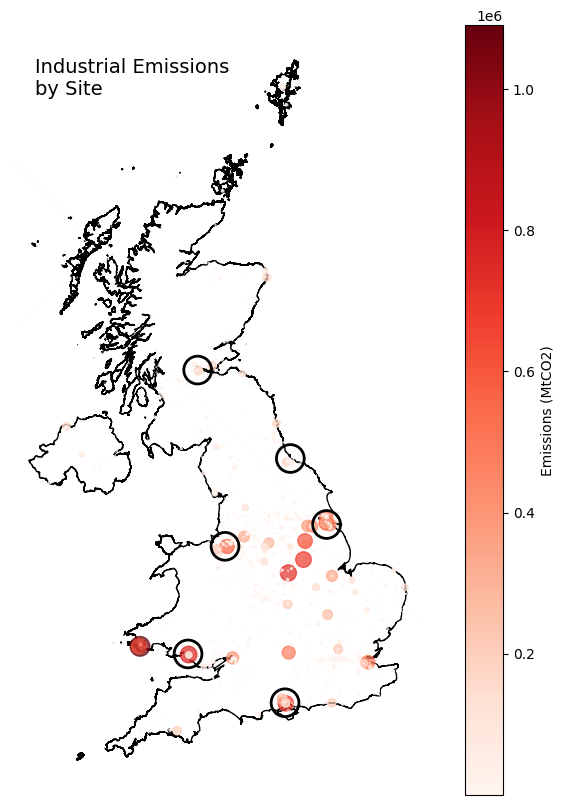

In [ ]:
### Plot the data

fig, ax = plt.subplots(figsize=(10, 10))

# Plot UK boundary first (base layer)
uk_boundary.plot(ax=ax, color='white', edgecolor='black', linewidth=1)

# Plot emissions on top, coloured by emission magnitude
cluster_analysis_gdf.plot(
    ax=ax,
    column='Emission',
    cmap='Reds',
    legend=True,
    legend_kwds={'label':'Emissions (MtCO2)'},
    alpha=0.7,
    markersize=cluster_analysis_gdf['Emission'] / cluster_analysis_gdf['Emission'].max() * 200  # optional scaling
)

# Add industrial clusters
xs = cluster_points.geometry.x
ys = cluster_points.geometry.y
ax.scatter(xs, ys, s=400, edgecolor="black", facecolor="none", linewidth=2.0)

ax.text(10000, 1160000, 'Industrial Emissions \nby Site', fontsize=14)
ax.axis('off')

plt.show()

In [ ]:
from libpysal.weights import DistanceBand
from esda.moran import Moran
import libpysal as lps

# threshold in meters (30 km = 30000 m), https://assets.publishing.service.gov.uk/media/5f9540b6d3bf7f35ea0aedb5/BEIS_-_CCUS_at_dispersed_sites_-_Report__1_.pdf
threshold = 30000

w_neighbour = lps.weights.DistanceBand.from_dataframe(cluster_analysis_gdf, threshold=threshold, binary=False)

result = Moran(cluster_analysis_gdf['Emission'], w_neighbour)
print(result.I)
print("p-value:", result.p_sim)

('WARNING: ', 26188, ' is an island (no neighbors)')
('WARNING: ', 26246, ' is an island (no neighbors)')
('WARNING: ', 26247, ' is an island (no neighbors)')
('WARNING: ', 26248, ' is an island (no neighbors)')
('WARNING: ', 26475, ' is an island (no neighbors)')
('WARNING: ', 26737, ' is an island (no neighbors)')
('WARNING: ', 26747, ' is an island (no neighbors)')
('WARNING: ', 26759, ' is an island (no neighbors)')
('WARNING: ', 26995, ' is an island (no neighbors)')
('WARNING: ', 27286, ' is an island (no neighbors)')
('WARNING: ', 27313, ' is an island (no neighbors)')
('WARNING: ', 27523, ' is an island (no neighbors)')
0.1525711594843194
p-value: 0.002


/Users/martinkelly/Documents/Coding/.venv/lib/python3.13/site-packages/scipy/sparse/_data.py:128: RuntimeWarning: divide by zero encountered in power
  return self._with_data(data ** n)
/Users/martinkelly/Documents/Coding/.venv/lib/python3.13/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 29 disconnected components.
 There are 12 islands with ids: 26188, 26246, 26247, 26248, 26475, 26737, 26747, 26759, 26995, 27286, 27313, 27523.
  w = W(neighbors, weights, ids, **kwargs)
/Users/martinkelly/Documents/Coding/.venv/lib/python3.13/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 29 disconnected components.
 There are 12 islands with ids: 26188, 26246, 26247, 26248, 26475, 26737, 26747, 26759, 26995, 27286, 27313, 27523.
  W.__init__(


In [ ]:
### Local moran

from esda.moran import Moran_Local
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_simulation

lisa = Moran_Local(cluster_analysis_gdf['Emission'], w_neighbour  )

cluster_analysis_gdf['lisa'] = lisa.Is
cluster_analysis_gdf['lisa_sig'] = lisa.p_sim
cluster_analysis_gdf['LISA_cluster'] = lisa.q
print(cluster_analysis_gdf.sample(5))

print('\n', cluster_analysis_gdf.LISA_cluster.value_counts())



       Year  PollutantID            Pollutant_Name  PlantID  \
27575  2023            2  Carbon Dioxide as Carbon    40090   
27651  2023            2  Carbon Dioxide as Carbon    40499   
27654  2023            2  Carbon Dioxide as Carbon    40503   
27137  2023            2  Carbon Dioxide as Carbon    13447   
26868  2023            2  Carbon Dioxide as Carbon     9855   

                                                    Site  Easting  Northing  \
27575  Queenslie Healthcare Waste Treatment and Trans...   266000    665900   
27651                                            Colwick   462579    340329   
27654                        Rownhams Generation Station   437244    116800   
27137                   10 South Colonnade, Canary Wharf   537374    180252   
26868                 Deeside Industrial Estate, Deeside   331070    371480   

                                            Operator  SectorID  \
27575            Tradebe Healthcare National Limited        21   
27651  Mercia 

/Users/martinkelly/Documents/Coding/.venv/lib/python3.13/site-packages/esda/moran.py:1354: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


Text(0.5, 0, 'Industrial emissions')

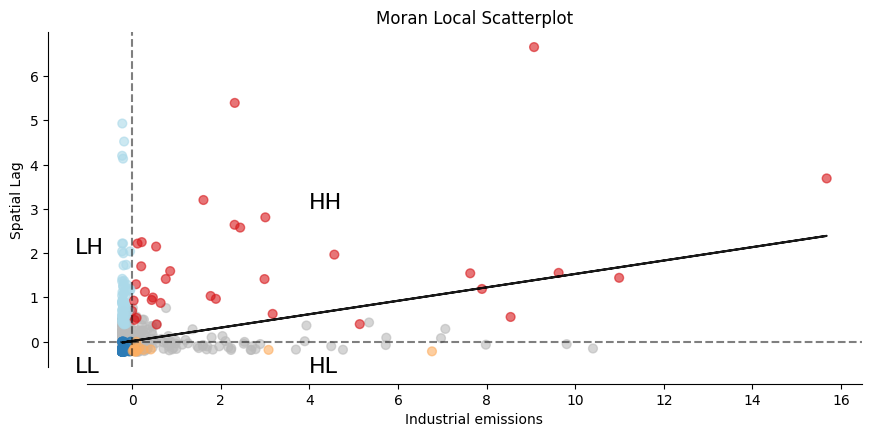

In [ ]:
#do lisa scatter plot
# "from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_simulation", these re functions for plot
# moran_scatterplot() is from splot package 

fig, ax = plt.subplots( 1,1, figsize = (10,10))

moran_scatterplot(lisa, p= 0.05, ax=ax) #p specify the sig

plt.text(4, 3, "HH", fontsize = 16)
plt.text(4, -0.7, "HL", fontsize = 16)
plt.text(-1.3, 2, "LH", fontsize = 16)
plt.text(-1.3, -0.7, "LL", fontsize = 16)
plt.xlabel('Industrial emissions')


In [ ]:
cluster_analysis_gdf.describe()

,Year,PollutantID,PlantID,Easting,Northing,SectorID,Emission,lisa,lisa_sig,LISA_cluster
count,1618.0,1618.0,1618.000000,1618.000000,1.618000e+03,1618.000000,1.618000e+03,1618.000000,1618.000000,1618.000000
mean,2023.0,2.0,16366.508653,409918.564277,3.716364e+05,14.353523,1.542075e+04,0.151346,0.193646,2.742892
std,0.0,0.0,12419.643860,108724.696365,2.028859e+05,8.289288,6.860499e+04,2.243664,0.157418,0.630616
min,2023.0,2.0,156.000000,36251.000000,2.530000e+04,1.000000,3.818182e-04,-1.574966,0.001000,1.000000
25%,2023.0,2.0,8708.250000,336155.000000,1.877725e+05,5.000000,5.019832e+02,-0.001396,0.037000,2.000000
50%,2023.0,2.0,11959.500000,415786.000000,3.547115e+05,14.000000,1.732222e+03,0.023012,0.172000,3.000000
75%,2023.0,2.0,14674.750000,495456.750000,4.657895e+05,23.000000,4.759532e+03,0.037337,0.328750,3.000000
max,2023.0,2.0,43443.000000,655360.000000,1.176450e+06,26.000000,1.090540e+06,60.300222,0.500000,4.000000


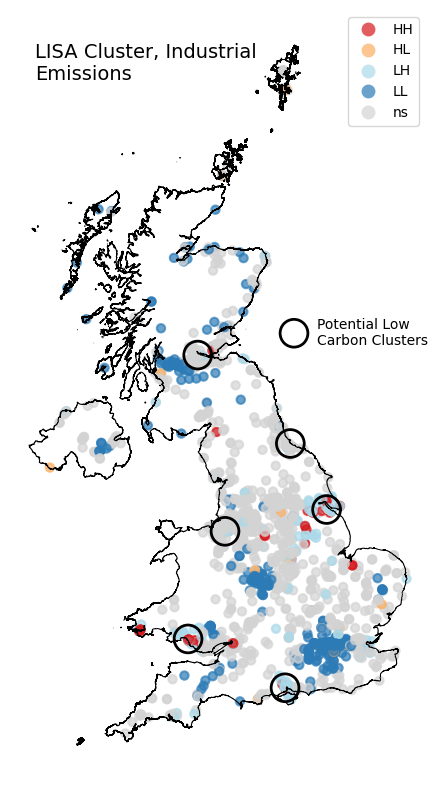

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

lisa_cluster(lisa, cluster_analysis_gdf , p = 0.1, alpha=0.7,
             ax= ax)
#setting p=0.1 means here we use a 10% significance level. e.g., Only clusters with p-values <= 0.1 are highlighted as significant.
# Lower p-values make it harder for an area to be labelled "significant". 

uk_boundary.boundary.plot(ax=ax, color='black', linewidth=0.8)

# Add industrial clusters
xs = cluster_points.geometry.x
ys = cluster_points.geometry.y
ax.scatter(xs, ys, s=400, edgecolor="black", facecolor="none", linewidth=2.0)

ax.scatter(460000, 720000, s=400, edgecolor="black", facecolor="none", linewidth=2.0)
ax.text(500000, 700000, "Potential Low \nCarbon Clusters", fontsize=10)

ax.text(10000, 1160000, 'LISA Cluster, Industrial \nEmissions', fontsize=14)
ax.set_axis_off()

plt.show()


# Alternative coding - Raster data

In [ ]:
# Create UK grid
cell_size = 15000  # 15 km in meters

minx, miny, maxx, maxy = uk_boundary.total_bounds

grid_cells = []
for x0 in np.arange(minx, maxx, cell_size):
    for y0 in np.arange(miny, maxy, cell_size):
        grid_cells.append(box(x0, y0, x0 + cell_size, y0 + cell_size))

grid_em = gpd.GeoDataFrame({"geometry": grid_cells}, crs="EPSG:27700")

# Keep only grid cells that intersect the UK
grid_em = grid_em[grid_em.intersects(uk_boundary.unary_union)]

/var/folders/j4/9zgf2vfj1djc1z4q879727140000gn/T/ipykernel_55356/1269448884.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_em = grid_em[grid_em.intersects(uk_boundary.unary_union)]


In [ ]:
# Create joint database
ie_raster = gpd.sjoin(industrial_emissions_gdf, grid_em, predicate="within")

# Sum emissions per grid cell
grid_em["emission"] = ie_raster.groupby("index_right")["Emission"].sum()
grid_em["emission"] = grid_em["emission"].fillna(0)

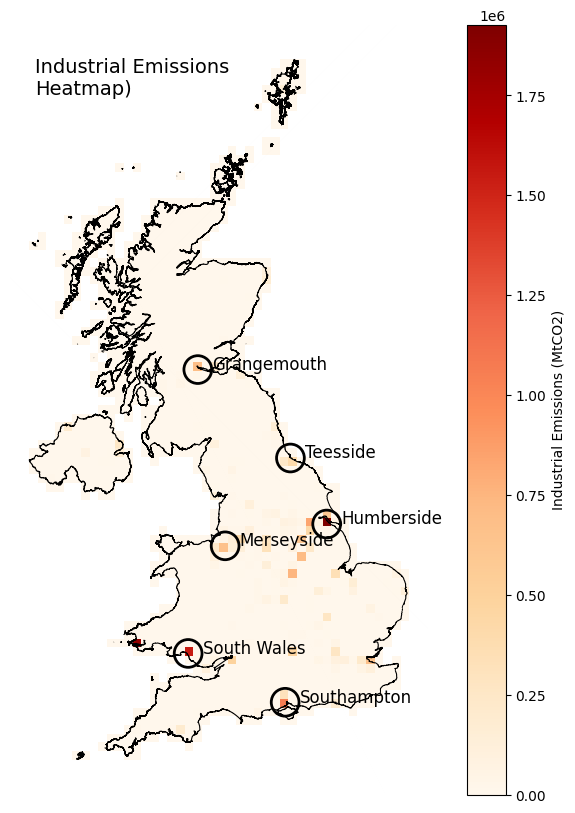

In [ ]:
# Cluster map
fig, ax = plt.subplots(figsize=(10, 10))

# Heatmap of emissions
grid_em.plot(
    column='emission',
    cmap='OrRd',
    linewidth=0,
    ax=ax,
    legend=True,
    legend_kwds={'label': "Industrial Emissions (MtCO2)"}
)

# UK boundary outline
uk_boundary.boundary.plot(ax=ax, color='black', linewidth=0.8)


# Add industrial clusters
xs = cluster_points.geometry.x
ys = cluster_points.geometry.y
ax.scatter(xs, ys, s=400, edgecolor="black", facecolor="none", linewidth=2.0)

# Labels for clusters
for idx, row in cluster_points.iterrows():
    ax.text(
        row.geometry.x + 25000,  # slight right offset
        row.geometry.y + 500,  # slight up offset
        row["Name"],
        fontsize=12
    )

ax.text(10000, 1160000, 'Industrial Emissions \nHeatmap)', fontsize=14)
ax.axis('off')

plt.show()

In [ ]:
# Neighbour weights
r_threshold = 30000

w_neighbour = lps.weights.DistanceBand.from_dataframe(grid_em, threshold=threshold, binary=False)

result = Moran(grid_em['emission'], w_neighbour)
print(result.I)
print("p-value:", result.p_sim)

('WARNING: ', 1444, ' is an island (no neighbors)')
0.06538065015005895
p-value: 0.002


/Users/martinkelly/Documents/Coding/.venv/lib/python3.13/site-packages/scipy/sparse/_data.py:128: RuntimeWarning: divide by zero encountered in power
  return self._with_data(data ** n)
/Users/martinkelly/Documents/Coding/.venv/lib/python3.13/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There is 1 island with id: 1444.
  w = W(neighbors, weights, ids, **kwargs)
/Users/martinkelly/Documents/Coding/.venv/lib/python3.13/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There is 1 island with id: 1444.
  W.__init__(


In [ ]:
### Local moran

from esda.moran import Moran_Local
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_simulation

lisa = Moran_Local(grid_em['emission'], w_neighbour  )

grid_em['lisa'] = lisa.Is
grid_em['lisa_sig'] = lisa.p_sim
grid_em['LISA_cluster'] = lisa.q
print(grid_em.sample(5))

print('\n', grid_em.LISA_cluster.value_counts())

                                               geometry     emission  \
710   POLYGON ((134883.807 935333.81, 134883.807 950...     0.000000   
1815  POLYGON ((344883.807 500333.81, 344883.807 515...     0.000000   
2863  POLYGON ((539883.807 425333.81, 539883.807 440...  1138.474503   
2034  POLYGON ((389883.807 140333.81, 389883.807 155...  5529.260651   
679   POLYGON ((134883.807 470333.81, 134883.807 485...     0.000000   

          lisa  lisa_sig  LISA_cluster  
710   0.026597     0.077             3  
1815  0.012731     0.386             3  
2863 -0.451707     0.001             2  
2034  0.016472     0.308             3  
679   0.026899     0.045             3  

 LISA_cluster
3    1056
2     259
1      80
4      50
Name: count, dtype: int64


/Users/martinkelly/Documents/Coding/.venv/lib/python3.13/site-packages/esda/moran.py:1354: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


Text(0.5, 0, 'Industrial emissions')

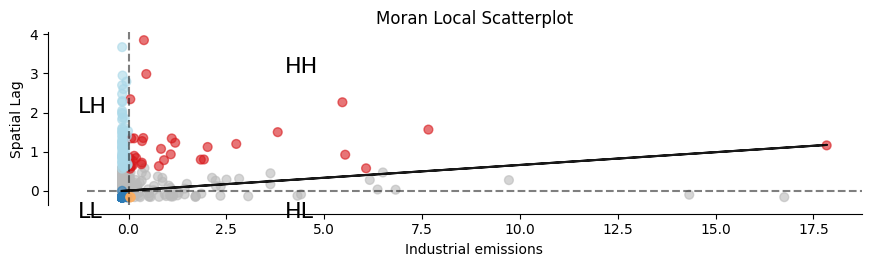

In [ ]:
#do lisa scatter plot
# "from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_simulation", these re functions for plot
# moran_scatterplot() is from splot package 

fig, ax = plt.subplots( 1,1, figsize = (10,10))

moran_scatterplot(lisa, p= 0.05, ax=ax) #p specify the sig

plt.text(4, 3, "HH", fontsize = 16)
plt.text(4, -0.7, "HL", fontsize = 16)
plt.text(-1.3, 2, "LH", fontsize = 16)
plt.text(-1.3, -0.7, "LL", fontsize = 16)
plt.xlabel('Industrial emissions')


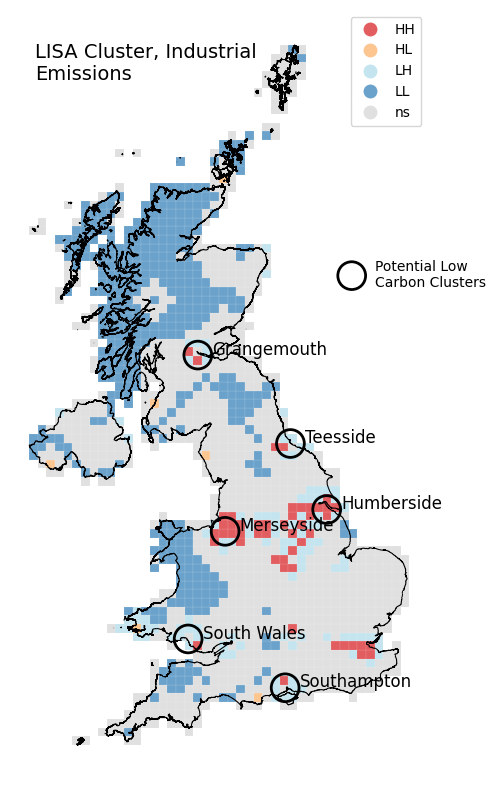

In [ ]:
## LISA Map

fig, ax = plt.subplots(figsize=(10,10))

lisa_cluster(lisa, grid_em , p = 0.1, alpha=0.7,
             ax= ax)
#setting p=0.1 means here we use a 10% significance level. e.g., Only clusters with p-values <= 0.1 are highlighted as significant.
# Lower p-values make it harder for an area to be labelled "significant". 

uk_boundary.boundary.plot(ax=ax, color='black', linewidth=0.8)

# Add industrial clusters
xs = cluster_points.geometry.x
ys = cluster_points.geometry.y
ax.scatter(xs, ys, s=400, edgecolor="black", facecolor="none", linewidth=2.0)

# Labels for clusters
for idx, row in cluster_points.iterrows():
    ax.text(
        row.geometry.x + 25000,  # slight right offset
        row.geometry.y + 500,  # slight up offset
        row["Name"],
        fontsize=12
    )

ax.scatter(560000, 820000, s=400, edgecolor="black", facecolor="none", linewidth=2.0)
ax.text(600000, 800000, "Potential Low \nCarbon Clusters", fontsize=10)

ax.text(10000, 1160000, 'LISA Cluster, Industrial \nEmissions', fontsize=14)
ax.set_axis_off()

plt.show()


# Non-uni analysis

### Industry in London

In [16]:
london_emissions = gpd.sjoin(cluster_analysis_gdf, m_london, predicate='within')
london_industry = london_emissions#[~london_emissions['Sector'].isin(['Major power producers', 'Minor power producers'])]

In [17]:
### LONDON PLOT ###


### Plot London
# Create interactive map
m = m_london.explore(
    color="black", 
    style_kwds={"fillColor": "white", "weight": 1}, 
    tooltip=False,
    name="London Boundary"
)

# Add emissions layer
london_emissions.explore(
    m=m,
    column='Sector',
    legend=True,
    marker_kwds={
        "radius": 5,      # <-- increase this (e.g. 8, 12, 15)
        "fill": True,
        "fillOpacity": 0.8
    },
    legend_kwds={'label': 'Sector)'},
    tooltip=['Site', 'Operator', 'Sector', 'Emission'],        # optional popup fields
    name="Industrial Emissions"
)

from pathlib import Path
import webbrowser
from IPython.display import IFrame

# 1) Choose a path to save the HTML
out_path = Path.home() / "Desktop" / "london_industry_map.html"   # change location/name as you like
out_path.parent.mkdir(parents=True, exist_ok=True)

# 2) Save the map (m must be a folium.Map)
m.save(str(out_path))

# 3a) Open in your default browser (optional)
webbrowser.open(out_path.as_uri())

# 3b) OR embed in a Jupyter notebook cell (optional)
IFrame(src=str(out_path), width=900, height=600)


In [ ]:
london_total_em = london_industry['Emission'].sum()

london_sector_em = (
    london_industry
    .groupby('Sector', as_index=False)['Emission']
    .sum()
    .sort_values('Emission', ascending=False)
).round()

london_sector_em = london_sector_em.rename(columns={'Emission':'Emissions, tCO2'})


In [ ]:
london_sector_count = (
    london_industry
    .groupby('Sector', as_index=False)['Emission']
    .sum()
    .sort_values('Emission', ascending=False)
).round()

london_sector_em = london_sector_em.rename(columns={'Emission':'Emissions, tCO2'})

In [ ]:
london_total_em = london_sector_em['Emissions, tCO2'].sum()
london_sector_em['Share (%)'] = (london_sector_em['Emissions, tCO2']/london_sector_em['Emissions, tCO2'].sum()).round(2)*100

In [ ]:
print(london_sector_em)
print(f"\nLondon's total industrial and commercial emissions were {london_total_em.round()} tCO2 in 2023")

                                    Sector  Emissions, tCO2  Share (%)
3                    Major power producers         230710.0       42.0
9   Waste collection, treatment & disposal         128678.0       24.0
7                    Public administration          70730.0       13.0
2           Food, drink & tobacco industry          67203.0       12.0
0                               Commercial          22870.0        4.0
6                 Other mineral industries           9500.0        2.0
4                    Minor power producers           7173.0        1.0
1                             Construction           2978.0        1.0
8                                 Vehicles           2647.0        0.0
10                        Water & sewerage           2256.0        0.0
5                            Miscellaneous           1390.0        0.0

London's total industrial and commercial emissions were 546135.0 tCO2 in 2023


In [ ]:
london_ordered = london_industry.sort_values("Emission", ascending=False)

london_ordered = london_ordered.loc[:,('Site',
                                            'Operator',
                                            'Sector',
                                            'Emission',
                                            'geometry'    
                                        )]

In [ ]:
london_ordered.head(20)

,Site,Operator,Sector,Emission,geometry
27408,Enfield Power Station,Uniper UK Ltd,Major power producers,226661.662015,POINT (536800 197700)
26179,Belvedere,Riverside Resource Recovery Ltd,"Waste collection, treatment & disposal",44391.211813,POINT (549690 180670)
27080,Silvertown,T&L Sugars Ltd,"Food, drink & tobacco industry",33225.172257,POINT (542250 180250)
26168,Edmonton,London Waste Ltd,"Waste collection, treatment & disposal",26762.523464,POINT (535800 192600)
26185,SELCHP,South East London Combined Heat & Power Ltd,"Waste collection, treatment & disposal",21670.964948,POINT (535830 177990)
26584,Erith,Archer Daniels Midland Erith Ltd,"Food, drink & tobacco industry",18980.618037,POINT (550500 179300)
27641,Beddington Energy Recovery Facility,VIRIDOR WASTE MANAGEMENT LTD,"Waste collection, treatment & disposal",18312.798258,POINT (529310 167260)
27756,Beddington ERF,Viridor South London Ltd,"Waste collection, treatment & disposal",14528.353312,POINT (529240 168460)
26516,Heathrow Airport,Heathrow Airport Ltd,Commercial,6666.717908,POINT (507400 176700)
27041,Stratford CHP Energy Centre,Cofely East London Energy,Public administration,6259.149161,POINT (538747 184829)


In [ ]:
london_ordered[london_ordered['Sector'] == "Public administration"].head(20)

,Site,Operator,Sector,Emission,geometry
27041,Stratford CHP Energy Centre,Cofely East London Energy,Public administration,6259.149161,POINT (538747 184829)
26575,St. Thomas' Hospital,Guys & St Thomas' Hospital NHS Trust,Public administration,6179.945195,POINT (530600 179300)
26576,Guys Hospital,Guys & St Thomas' NHS Trust,Public administration,5735.882624,POINT (532800 179800)
26657,Royal Free Hospital,Royal Free Hampstead NHS Trust,Public administration,5495.556327,POINT (527297 185410)
27040,Kings Yard CHP Energy Centre,Cofely East London Energy,Public administration,5397.878741,POINT (537571 184555)
27391,Electrical Engineering Building,"Imperial College of Science, Technology and Me...",Public administration,5245.072454,POINT (526500 179500)
26672,St Georges Hospital,St Georges Healthcare NHS Trust,Public administration,5159.351228,POINT (526925 171325)
27034,Kings College Hospital,Dalkia Utility Services,Public administration,5098.817356,POINT (532587 176187)
26594,Great Ormond Street Hospital,Great Ormond Street Hospital for Children NHS ...,Public administration,3397.651961,POINT (530500 182000)
27019,Charing Cross Hospital,Imperial College Healthcare NHS Trust,Public administration,2939.352755,POINT (523600 177900)


In [18]:
### GB PLOT ###


### Plot GB
# Create interactive map
m = m_regions.explore(
    color="black", 
    style_kwds={"fillColor": "white", "weight": 1}, 
    tooltip=False,
    name="London Boundary"
)

# Add emissions layer
cluster_analysis_gdf.explore(
    m=m,
    column='Sector',
    legend=True,
    marker_kwds={
        "radius": 5,      # <-- increase this (e.g. 8, 12, 15)
        "fill": True,
        "fillOpacity": 0.8
    },
    legend_kwds={'label': 'Sector)'},
    tooltip=['Site', 'Operator', 'Sector', 'Emission'],        # optional popup fields
    name="Industrial Emissions"
)

from pathlib import Path
import webbrowser
from IPython.display import IFrame

# 1) Choose a path to save the HTML
out_path = Path.home() / "Desktop" / "UK_industry_map.html"   # change location/name as you like
out_path.parent.mkdir(parents=True, exist_ok=True)

# 2) Save the map (m must be a folium.Map)
m.save(str(out_path))

# 3a) Open in your default browser (optional)
webbrowser.open(out_path.as_uri())

# 3b) OR embed in a Jupyter notebook cell (optional)
IFrame(src=str(out_path), width=900, height=600)
